In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
from deap import algorithms, base, creator, tools

## Loading data

In [78]:
returns = pd.read_csv("../data/weekly_returns.csv",index_col="Date")
ibov_return = pd.read_csv("../data/weekly_ibov.csv",index_col="Date")
volatilities = pd.read_csv("../data/volatility_garch_1_1_7.csv",index_col="Date")
selic = pd.read_csv("../data/weekly_selic.csv",index_col="Date")


returns.index = pd.to_datetime(returns.index)
ibov_return.index = pd.to_datetime(ibov_return.index)
volatilities.index = pd.to_datetime(volatilities.index)
selic.index = pd.to_datetime(selic.index)


selic

,Selic
Date,
2010-01-04,0.001647
2010-01-11,0.001647
2010-01-18,0.001647
2010-01-25,0.001647
2010-02-01,0.001647
...,...
2021-11-29,0.001464
2021-12-06,0.001464
2021-12-13,0.001629


The function below is responsible for getting the portifolio return based on each asset return and the weights given for each asset.

*Parameters:*
 - weights: array with each element being the weight assinged for each asset.
 - asset_returns: array with each element being the asset return. 

*Disclaimer:*
 - Each asset expected return may be obtained with different techniques. In this first version, the expected return is simply the last observed return. In other words, $\hat{y}_t=y_{t-1}$ 
 - Asset returns were obtained with the log-return of the asset Adjusted Closed Price.

In [79]:
def portifolio_return(weights, asset_returns):
    
    '''
    First version -> the expected return from each asset is exactly the last return, which is inspired on Random Walk
    Weights will be othe GA individual
    '''
    
    port_ret = np.dot(weights,asset_returns)
    
    return port_ret

The function below is responsible for getting the portifolio volatility based on each asset volatility and the weights given for each asset.

*Parameters:*
 - weights: array with each element being the weight assinged for each asset.
 - asset_volatilities: array with each element being the asset volatility predicted by a GARCH Model. 

*Disclaimer:*
 - In the current version, volatilities are being estimated through historical variance and covariance

In [80]:

def portifolio_volatility(weights,asset_volatilities,cov_matrix):
    
    weights_np = np.array(weights)
    
    port_vol = np.sqrt(np.dot(weights_np.T,np.dot(cov_matrix,weights_np)))
    
    return port_vol

In [81]:
weights = np.ones(len(returns.iloc[0,:]))/len(returns.iloc[0,:])


portifolio_return(asset_returns=returns.iloc[0,:],
                  weights=weights)



0.023544051177480988

In [82]:
weights

array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158])

In [83]:
# portifolio_volatility(weights = weights,
#                       asset_volatilities = volatilities.iloc[15,:])

## GA Optimization

Por enquanto eu apenas estou maximizando retorno, sem olhar a volatilidade

In [84]:
#First, only maximize portfolio return
def objective_function(individual):

    num = portifolio_return(individual,asset_returns)-selic_week
    den = portifolio_volatility(individual,asset_volatilities,cov_matrix)
    ret = (num/den).values[0]
    
    # print("frac = %.4f / %.4f"%(num,den)) 
    # print(ret.values[0])         
    
    return (ret),
    

In [85]:
def feasible(individual):
    cond1 = 1-sum(individual)>0 
    cond2 = sum(individual)-1<10e-7
    
    all_positive = True
    for gene in individual:
        if gene < 0:
            all_positive = False
            
    #port_vol = portifolio_volatility(individual,asset_volatilities)
    #cond_vol = port_vol <= 0.15
    return cond1 and cond2 and all_positive  #and cond_vol

In [86]:
def distance(individual):
    
    return (abs(sum(individual)-1)),

### GA setup

In [87]:
creator.create('FitnessMax',base.Fitness,weights=(1.0,)) 
creator.create('Individual',list,fitness=creator.FitnessMax) 

c:\Users\matno\anaconda3\envs\compEvol\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\matno\anaconda3\envs\compEvol\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [88]:
toolbox = base.Toolbox()

toolbox.register("attr_weight", random.uniform, 0, 1/19)

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_weight, n=19)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  

In [89]:
toolbox.register("evaluate", objective_function)     
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, 0, distance))

In [90]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register('mutate', tools.mutGaussian, mu=0, sigma=1, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [91]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('avg',np.mean)
stats.register('std',np.std)
stats.register('max',np.max)
stats.register('min',np.min)

In [92]:
train_returns = returns[returns.index.year < 2020]
test_returns =  returns[returns.index.year >= 2020]

train_volatilities = volatilities[volatilities.index.year < 2020]
test_volatilities = volatilities[volatilities.index.year >= 2020]

## Hyperparameter Search on training dataset

In [93]:
hyperparameters = {"population":[50,100],
                   "cxpb":[0.3,0.5],
                    "mutpb":[0.05,0.1],
                    "ngen":[20,50]}

keys, values = zip(*hyperparameters.items())
hyperparameters_permutations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print("Number of models to do compared = %d"%len(hyperparameters_permutations))

Number of models to do compared = 16


In [94]:
ibov_return.index[0]

Timestamp('2010-01-11 00:00:00')

In [95]:
best_cummulative_return = 0
best_hyperparametrs = {}
window = 14
comparing_hyperparameters = []

global_list_weights = []

c=0
for parameters in hyperparameters_permutations:
    optimal_returns = {}
    best_individuals = {}
    
    hof = tools.HallOfFame(1)
    pop = toolbox.population(n=parameters["population"]) 
    cxpb = parameters["cxpb"]
    mutpb = parameters["mutpb"]
    ngen = parameters["ngen"]
    
    list_weights = []
    
    for week in range(window,len(train_returns)):
        
        # Idx is the current week
        idx = train_returns.index[week]
        
        # Individual asset return for that week
        asset_returns = train_returns.loc[idx,:]
        #Individual Asset Volatility for that week
        asset_volatilities = train_volatilities.loc[idx,:]
        # Selic from that week
        selic_week= selic.loc[idx]
        
        # Return covariance matrix considering the last window weeks
        cov_matrix = train_returns.iloc[week-window:week,:].cov()

        pop,log = algorithms.eaSimple(population=pop, toolbox=toolbox, cxpb=cxpb, mutpb=mutpb,
                                ngen=ngen, stats=stats, halloffame=hof,verbose=False)
        

        best_individuals[idx] = hof[0]
        list_weights.append(best_individuals)
        optimal_returns[idx] = objective_function(hof[0])
        
    global_list_weights.append(list_weights)
    optimal_returns = pd.DataFrame(index=optimal_returns.keys(),data=optimal_returns.values())
    portifolio_cummulative_return = optimal_returns.cumsum()
    
    parameters["cummulative return"] = portifolio_cummulative_return
    comparing_hyperparameters.append(parameters)
    
    
    if portifolio_cummulative_return.values[-1][0] > best_cummulative_return:
        best_hyperparametrs = parameters
    
    if c == 1:
        break
    c+=1

print("Best Hyperparameters are:")
print(best_hyperparametrs)

Best Hyperparameters are:
{'population': 50, 'cxpb': 0.3, 'mutpb': 0.05, 'ngen': 50, 'cummulative return':                     0
2010-04-12  -0.029962
2010-04-19   0.102042
2010-04-26  -0.620971
2010-05-03  -2.234970
2010-05-10  -1.636402
...               ...
2019-12-02  10.584018
2019-12-09  10.912776
2019-12-16   9.914818
2019-12-23  10.997375
2019-12-30   9.785547

[508 rows x 1 columns]}


In [96]:
# gloabl_list_weights

## Best Hyperparameters result on training data

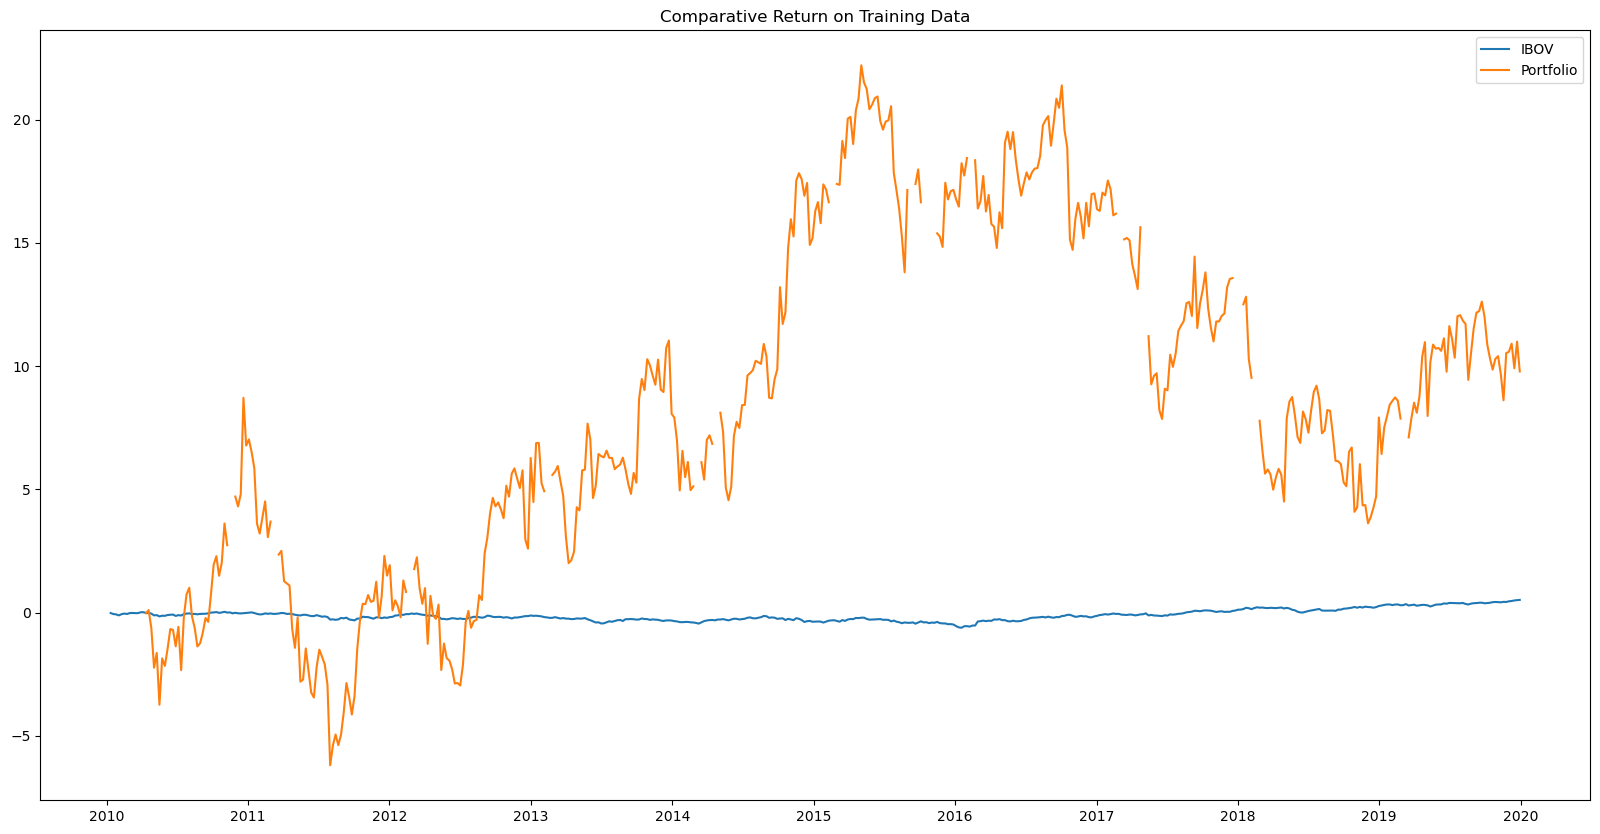

In [97]:
ibov_cummulative_return = ibov_return.cumsum()

train_ibov = ibov_cummulative_return[ibov_cummulative_return.index.year<2020]
test_ibov = ibov_cummulative_return[ibov_cummulative_return.index.year>=2020]

plt.figure(figsize=(20,10))
plt.plot(train_ibov,label="IBOV")
plt.plot(best_hyperparametrs["cummulative return"],label="Portfolio")
plt.title("Comparative Return on Training Data")
plt.legend()
plt.show()

## Best Hyperparameters result on test data

In [98]:
best_individuals = {}
optimal_returns = {}

hof = tools.HallOfFame(1)
pop = toolbox.population(n=best_hyperparametrs["population"]) 

cxpb = best_hyperparametrs["cxpb"]
mutpb = best_hyperparametrs["mutpb"]
ngen = best_hyperparametrs["ngen"]

for week in range(window,len(test_returns)):
        
        idx = test_returns.index[week]
        
        asset_returns = test_returns.loc[idx,:]
        asset_volatilities = test_volatilities.loc[idx,:]
        selic_week= selic.loc[idx]
        
        cov_matrix = test_returns.iloc[week-window:week,:].cov()

        pop,log = algorithms.eaSimple(population=pop, toolbox=toolbox, cxpb=cxpb, mutpb=mutpb,
                                ngen=ngen, stats=stats, halloffame=hof,verbose=False)
        

        best_individuals[idx] = hof[0]
        optimal_returns[idx] = objective_function(hof[0])
        
optimal_returns = pd.DataFrame(index=optimal_returns.keys(),data=optimal_returns.values())
optimal_returns.rename(columns={0:"Return"},inplace=True)    

portifolio_cummulative_return = optimal_returns.cumsum()
    

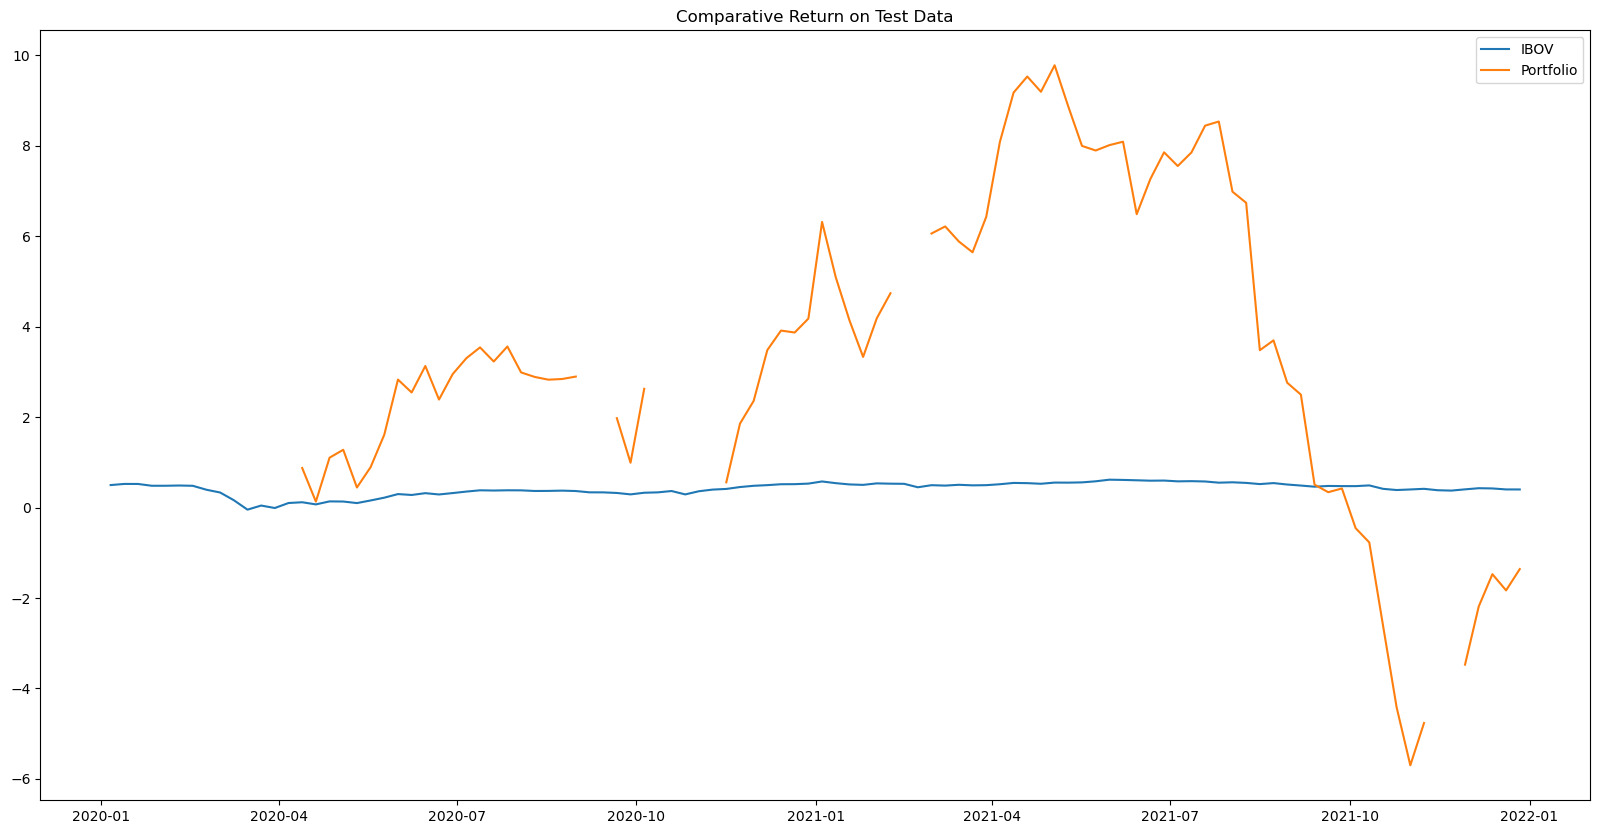

In [99]:
plt.figure(figsize=(20,10))
plt.plot(test_ibov,label="IBOV")
plt.plot(portifolio_cummulative_return,label="Portfolio")
plt.title("Comparative Return on Test Data")
plt.legend()
plt.show()